Image Segmentation with uNet

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys

print(sys.version)



2023-11-27 19:47:38.837440: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 19:47:38.837487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 19:47:38.839752: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 19:47:39.084373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3.9.18 (main, Aug 25 2023, 13:20:14) 
[GCC 11.4.0]


In [2]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = './Potsdam/Train/'

train_ids = next(os.walk(TRAIN_PATH))[1]

X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)



In [3]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    # Construct paths for image and mask
    file_prefix = 'top_potsdam_' + id_.replace("t","")
    # Construct paths for image and mask
    img_path = os.path.join(TRAIN_PATH, id_, file_prefix + '_RGB.tif')
    mask_path = os.path.join(TRAIN_PATH, id_, file_prefix + '_label.tif')
    # Read and resize the image
    img = imread(img_path)[:,:,:IMG_CHANNELS]
    #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  # Store the resized image

    # Initialize an empty mask
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    # Read, resize and expand dimensions of the mask
    mask_ = imread(mask_path)[:,:,1]
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    # Combine with the existing mask
    mask = np.maximum(mask, mask_)

    # Store the mask
    y[n] = mask


100%|██████████| 20102/20102 [02:48<00:00, 119.38it/s]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

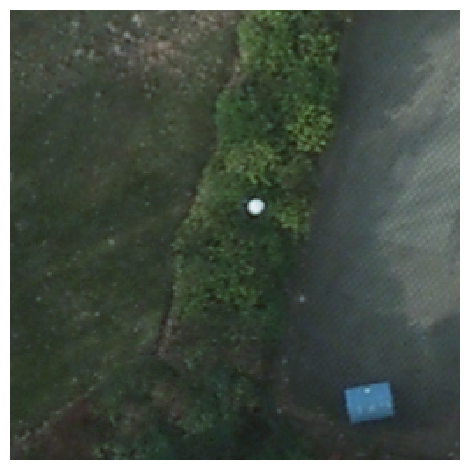

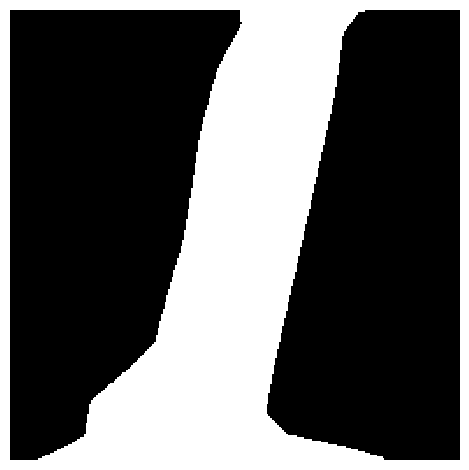

In [5]:
image_x = random.randint(0, len(X_train))
plt.axis("off")
imshow(X_train[image_x])
plt.show()
plt.axis("off")
imshow(np.squeeze(y_train[image_x]))
plt.show()

In [6]:
num_classes = 1

In [7]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


2023-11-27 19:51:13.217045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 19:51:13.221599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 19:51:13.221784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [8]:
tf.keras.utils.plot_model(model, "model.png")


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [8]:
#callbacks = [
 #   tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  #  tf.keras.callbacks.TensorBoard(log_dir='logs')]

model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=25)

2023-11-27 19:51:21.482528: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2647916544 exceeds 10% of free system memory.
2023-11-27 19:51:23.373834: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 882638848 exceeds 10% of free system memory.
2023-11-27 19:51:23.933569: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2647916544 exceeds 10% of free system memory.
2023-11-27 19:51:25.246028: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 882638848 exceeds 10% of free system memory.


Epoch 1/25


2023-11-27 19:51:27.473550: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-27 19:51:27.866188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-27 19:51:30.205609: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb85449f5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-27 19:51:30.205631: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2023-11-27 19:51:30.216782: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-27 19:51:30.316033: I ./tensorflow/compiler/jit/device_compiler.h:186] Compil

842/842 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.8542

2023-11-27 19:53:58.888488: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1304297472 exceeds 10% of free system memory.


842/842 [==============================] - 165s 186ms/step - loss: 0.3335 - accuracy: 0.8542 - val_loss: 0.3315 - val_accuracy: 0.8624
Epoch 2/25
842/842 [==============================] - 149s 177ms/step - loss: 0.2582 - accuracy: 0.8898 - val_loss: 0.2384 - val_accuracy: 0.9008
Epoch 3/25
842/842 [==============================] - 149s 177ms/step - loss: 0.2279 - accuracy: 0.9049 - val_loss: 0.2560 - val_accuracy: 0.8978
Epoch 4/25
842/842 [==============================] - 145s 173ms/step - loss: 0.2131 - accuracy: 0.9114 - val_loss: 1.0289 - val_accuracy: 0.5546
Epoch 5/25
842/842 [==============================] - 144s 172ms/step - loss: 0.2014 - accuracy: 0.9167 - val_loss: 0.2356 - val_accuracy: 0.8953
Epoch 6/25
842/842 [==============================] - 147s 175ms/step - loss: 0.1929 - accuracy: 0.9206 - val_loss: 0.1967 - val_accuracy: 0.9186
Epoch 7/25
842/842 [==============================] - 149s 177ms/step - loss: 0.1854 - accuracy: 0.9239 - val_loss: 0.1791 - val_accura

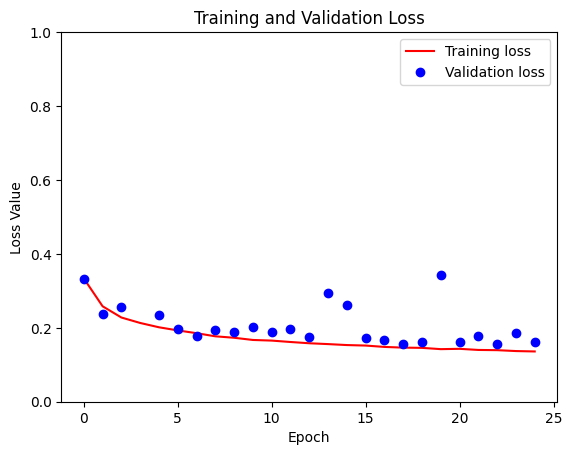

In [9]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-11-27 19:10:52.376773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 19:10:52.623002: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


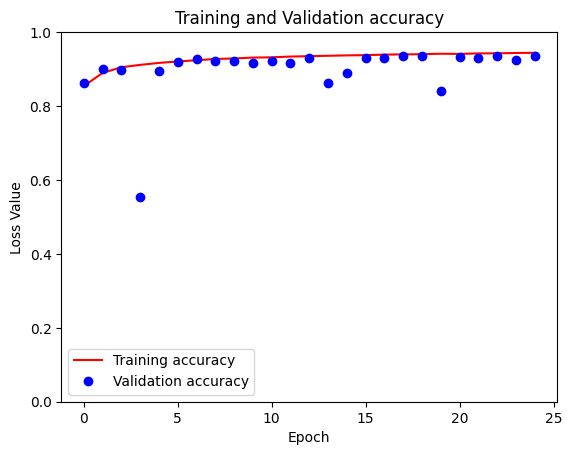

In [10]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure()
plt.plot(accuracy, 'r', label='Training accuracy')
plt.plot(val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input image', 'True mask', 'Predicted mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [89]:
i = random.randint(0, len(X_test))
sample_image = X_test[i]
sample_mask = y_test[i]

In [90]:
prediction = model.predict(sample_image[tf.newaxis, ...])[0]

1/1 [==============================] - 0s 18ms/step


In [91]:
predicted_mask = (prediction > 0.50).astype(np.uint8)

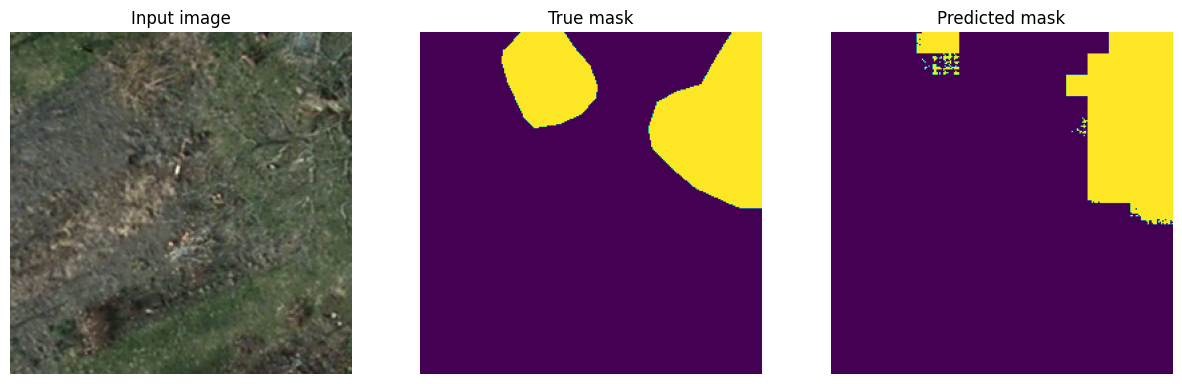

In [92]:
display([sample_image, sample_mask, predicted_mask])

In [54]:
model.save('./model.keras')